In [1]:
!pip install -q skforecast==0.4.2
!pip install xgboost

In [2]:
!pip install lightgbm

In [3]:
!pip install catboost

In [4]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import pyodbc
from datetime import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [5]:

# Funciones generales
# ==============================================================================
def get_connection_string():
    server = 'RECALDE\SQLEXPRESS'
    database = 'DMT_BIKE_SHARING'
    username = 'sa'
    password = 'chespi'
    driver = '{ODBC Driver 17 for SQL Server}'
        
    return f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};'

def get_blob_to_df(table_name : str, connection_str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql(query, conn)

        return (True, df)
    except Exception as e:
        return (False, str(e))
    
def guardar_resultados(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo,            # Nombre del modelo
        'EXECUTION_DATE': fecha_ejecucion  # Fecha de ejecución
    })
    
    return resultados

def guardar_pronostico(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo            # Nombre del modelo
    })
    
    return resultados

def upload_df_to_blob(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None

        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()

            # Obtener nombres de columnas y valores de cada fila como tuplas
            columns = ','.join(df.columns)

            # Crear comando SQL para insertar los datos en lotes
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({','.join(['?'] * len(df.columns))})"
            cursor.fast_executemany = True
            cursor.executemany(cmd_insert, df.values.tolist())

        return True, ""
    except Exception as e:
        return False, str(e)

In [6]:
# Configura la conexión a tu base de datos SQL Server
cnn = get_connection_string()

# Query SQL para extraer datos
_, datos = get_blob_to_df(table_name = 'dbo.vw_FACT_BIKE_SHARING_FORECASTING', connection_str = cnn)
datos

date_time  hour  month  weekday  holiday  workingday weather  \
0     2011-02-01 06:00:00     6      2        3        0           1    rain   
1     2011-02-01 07:00:00     7      2        3        0           1    rain   
2     2011-02-01 08:00:00     8      2        3        0           1    rain   
3     2011-02-01 09:00:00     9      2        3        0           1    mist   
4     2011-02-01 10:00:00    10      2        3        0           1    mist   
...                   ...   ...    ...      ...      ...         ...     ...   
17539 2011-01-05 00:00:00    24      1        4        0           1   clear   
17540 2011-01-05 01:00:00     1      1        4        0           1   clear   
17541 2011-01-05 02:00:00     2      1        4        0           1   clear   
17542 2011-01-05 03:00:00     3      1        4        0           1   clear   
17543 2011-01-05 04:00:00     4      1        4        0           1   clear   

       temp   atemp   hum  windspeed  users  TIPO_CONJUNTO  
0      5.74  10.605  93.0     0.0000     22              0  
1      6.56  11.365  93.0     0.0000     52              0  
2      6.56  11.365  93.0     0.0000    135              0  
3      6.56  11.365  93.0     0.0000    116              0  
4      6.56  11.365  93.0     0.0000     47              0  
...     ...     ...   ...        ...    ...            ...  
17539  8.20  12.880  64.0     0.0000      6              0  
17540  6.56   9.850  74.0     6.0032      6              0  
17541  6.56   9.850  74.0     6.0032      2              0  
17542  6.56   9.850  74.0     6.0032      2              0  
17543  9.84  11.365  48.0    15.0013      2              0  

[17544 rows x 13 columns]

In [7]:
# Verifica si 'date_time' ya es el índice
if 'date_time' not in datos.columns and datos.index.name == 'date_time':
    # Si 'date_time' ya es el índice, solo asegúrate de que sea datetime
    datos.index = pd.to_datetime(datos.index)
else:
    # Si 'date_time' es una columna, conviértela a datetime y establécela como índice
    datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
    datos = datos.set_index('date_time')

# Ajustar la frecuencia del DataFrame a intervalos horarios
datos = datos.asfreq('H')

# Ordenar el DataFrame por el índice (date_time)
datos = datos.sort_index()

# Muestra el DataFrame
print(datos)

                     hour  month  weekday  holiday  workingday weather   temp  \
date_time                                                                       
2011-01-01 00:00:00    24      1        7        0           0   clear   9.84   
2011-01-01 01:00:00     1      1        7        0           0   clear   9.02   
2011-01-01 02:00:00     2      1        7        0           0   clear   9.02   
2011-01-01 03:00:00     3      1        7        0           0   clear   9.84   
2011-01-01 04:00:00     4      1        7        0           0   clear   9.84   
...                   ...    ...      ...      ...         ...     ...    ...   
2012-12-31 19:00:00    19     12        2        0           1    mist  10.66   
2012-12-31 20:00:00    20     12        2        0           1    mist  10.66   
2012-12-31 21:00:00    21     12        2        0           1   clear  10.66   
2012-12-31 22:00:00    22     12        2        0           1   clear  10.66   
2012-12-31 23:00:00    23   

In [8]:
print(datos.index.min(), datos.index.max())  # Muestra el rango de fechas
print(datos.index.dtype)  # Confirma que el índice es de tipo datetime
print(datos.info())  # Muestra información general del DataFrame

2011-01-01 00:00:00 2012-12-31 23:00:00
datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour           17544 non-null  int64  
 1   month          17544 non-null  int64  
 2   weekday        17544 non-null  int64  
 3   holiday        17544 non-null  int64  
 4   workingday     17544 non-null  int64  
 5   weather        17544 non-null  object 
 6   temp           17544 non-null  float64
 7   atemp          17544 non-null  float64
 8   hum            17544 non-null  float64
 9   windspeed      17544 non-null  float64
 10  users          17544 non-null  int64  
 11  TIPO_CONJUNTO  17544 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 1.7+ MB
None


In [9]:
datos

hour  month  weekday  holiday  workingday weather   temp  \
date_time                                                                       
2011-01-01 00:00:00    24      1        7        0           0   clear   9.84   
2011-01-01 01:00:00     1      1        7        0           0   clear   9.02   
2011-01-01 02:00:00     2      1        7        0           0   clear   9.02   
2011-01-01 03:00:00     3      1        7        0           0   clear   9.84   
2011-01-01 04:00:00     4      1        7        0           0   clear   9.84   
...                   ...    ...      ...      ...         ...     ...    ...   
2012-12-31 19:00:00    19     12        2        0           1    mist  10.66   
2012-12-31 20:00:00    20     12        2        0           1    mist  10.66   
2012-12-31 21:00:00    21     12        2        0           1   clear  10.66   
2012-12-31 22:00:00    22     12        2        0           1   clear  10.66   
2012-12-31 23:00:00    23     12        2        0           1   clear  10.66   

                      atemp   hum  windspeed  users  TIPO_CONJUNTO  
date_time                                                           
2011-01-01 00:00:00  14.395  81.0     0.0000     16              0  
2011-01-01 01:00:00  13.635  80.0     0.0000     40              0  
2011-01-01 02:00:00  13.635  80.0     0.0000     32              0  
2011-01-01 03:00:00  14.395  75.0     0.0000     13              0  
2011-01-01 04:00:00  14.395  75.0     0.0000      1              0  
...                     ...   ...        ...    ...            ...  
2012-12-31 19:00:00  12.880  60.0    11.0014    119              1  
2012-12-31 20:00:00  12.880  60.0    11.0014     89              1  
2012-12-31 21:00:00  12.880  60.0    11.0014     90              1  
2012-12-31 22:00:00  13.635  56.0     8.9981     61              1  
2012-12-31 23:00:00  13.635  65.0     8.9981     49              1  

[17544 rows x 12 columns]

Los datos empleados en este documento representan el uso, a nivel horario, del sistema de alquiler de bicicletas en la ciudad de Washington D.C. durante los años 2011 y 2012. Además del número de usuarios por hora, se dispone de información sobre las condiciones meteorológicas y sobre los días festivos. Los datos originales se han obtenido del UCI Machine Learning Repository y han sido limpiados previamente (código) aplicando las siguientes modificaciones :

* Columnas renombradas con nombres más descriptivos.
* Categorías de la variable meteorológica renombradas. La categoría de heavy rain, se ha combinado con la de rain.
* Variables de temperatura, humedad y viento desnormalizadas.
* Creada variable date_time y establecida como índice.
* Imputación de valores missing mediante forward fill.

El data set resultante contiene las columnas:
|columna|descripción|
|-|-|
|date_time| fecha y hora.|
|month | mes (1 al 12).|
|hour | hora (0 al 23).|
|holiday | si el día es festivo o no <br>(obtenido de from http://dchr.dc.gov/page/holiday-schedule).|
|weekday | día de la semana (Lunes=0, Domingo=6).|
|workingday | si es un día laboral.|
|weathersit | la meteorología del día (clear, mist, rain).|
|temp | temperatura registrada.|
|atemp | sensación térmica.|
|hum| humedad registrada.|
|windspeed | velocidad del viento registrada.|
|users | usuarios totales del servicio de alquiler de bicicletas.|

In [10]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2012-03-31 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Fechas validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


## Representación de la serie temporal

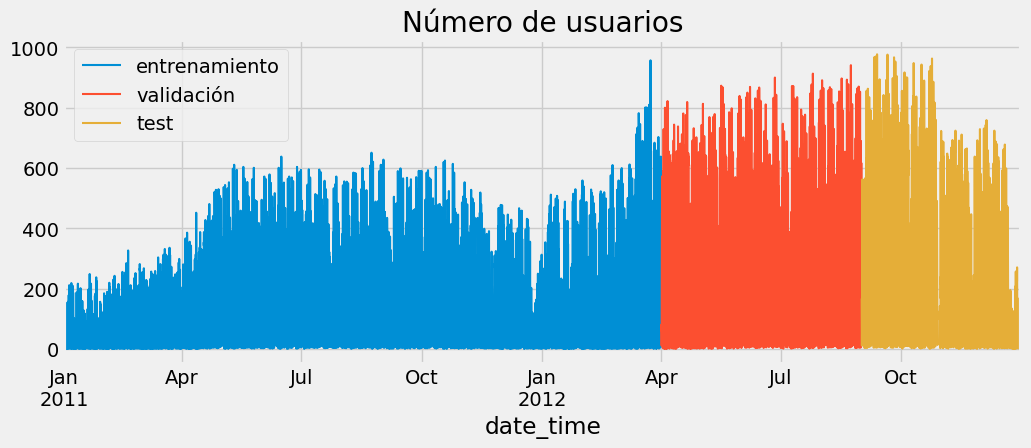

In [11]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['users'].plot(ax=ax, label='entrenamiento')
datos_val['users'].plot(ax=ax, label='validación')
datos_test['users'].plot(ax=ax, label='test')
ax.set_title('Número de usuarios')
ax.legend();

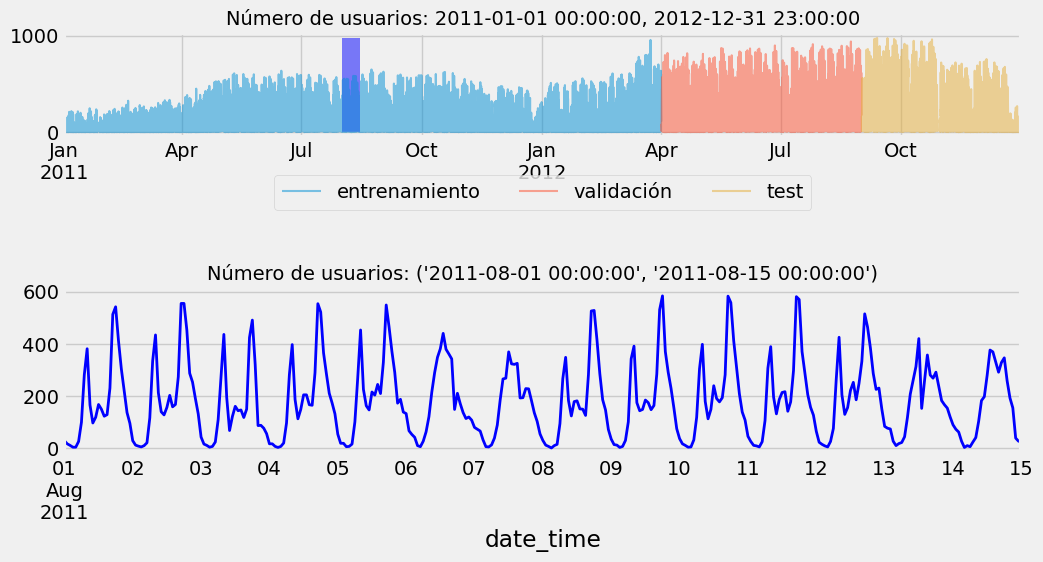

In [12]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['users'].plot(ax=main_ax, label='entrenamiento', alpha=0.5)
datos_val['users'].plot(ax=main_ax, label='validación', alpha=0.5)
datos_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['users'])
max_y = max(datos['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

datos.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Número de usuarios: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [13]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos.loc[:fin_train, 'particion'] = 'entrenamiento'
datos.loc[fin_train:fin_validacion, 'particion'] = 'validación'
datos.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = datos.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'particion',
    title  = 'Número de usuarios',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

datos=datos.drop(columns='particion')

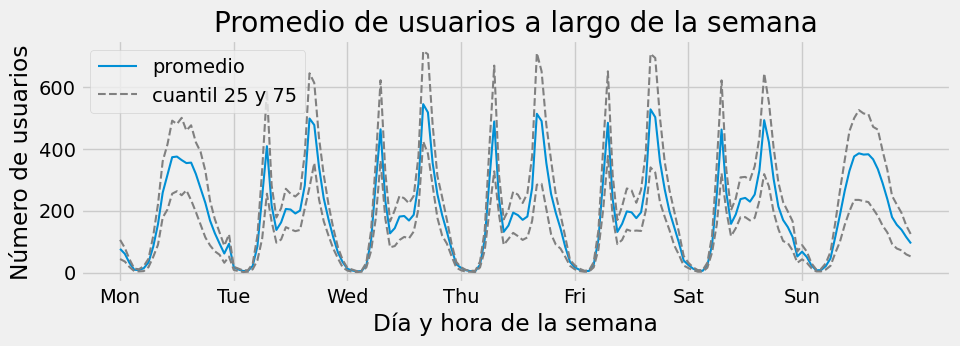

In [14]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = datos.groupby(["weekday", "hour"])["users"].mean()
q25_dia_hora = datos.groupby(["weekday", "hour"])["users"].quantile(0.25)
q75_dia_hora = datos.groupby(["weekday", "hour"])["users"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de usuarios a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="Número de usuarios"
)

ax.legend();

## Gráficos de autocorrelación

In [15]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_acf(datos['users'], ax=ax, lags=72)
#plot_acf(data_a, lags=90)
plt.show()

In [16]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_pacf(datos['users'], ax=ax, lags=72, method='ywm')
plt.show()

## XGBoost
XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

Como primera aproximación se utiliza un modelo autorregresivo que utiliza como predictores valores pasados (lags) de la propia variable respuesta. Dada la elevada cantidad de hiperparámetros que tienen los modelos de gradient boosting, se emplea una estrategia de gridsearch combinada con backtesting para identificar la configuración con la que se obtienen mejores predicciones.

In [17]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training 

In [18]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:fin_validacion, 'users'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [04:39<00:00, 69.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 14693.447252106347



# Resultados Grid Search
# ==============================================================================
resultados_grid

## Backtesting periodo de test

In [19]:
len(datos.loc[:fin_validacion])

14616

In [20]:
# Backtesting
# ==============================================================================
#fin_validacion = '2012-08-31 23:59:00'
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['users'],
    initial_train_size = len(datos.loc[:fin_validacion]),
    #fin_train = 18000,
    steps      = 60,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [13274.09747759]


In [21]:
predicciones

pred
2012-09-01 00:00:00  127.483398
2012-09-01 01:00:00   74.127693
2012-09-01 02:00:00   44.490276
2012-09-01 03:00:00   15.295521
2012-09-01 04:00:00    3.550442
...                         ...
2012-12-31 19:00:00  107.911758
2012-12-31 20:00:00   81.351379
2012-12-31 21:00:00   57.024990
2012-12-31 22:00:00   36.901165
2012-12-31 23:00:00   23.825842

[2928 rows x 1 columns]

In [22]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_BIKE_SHARING', connection_str = cnn)

(True, '')

In [23]:
forecaster.fit(y=datos_train['users'])

In [24]:
data1 = forecaster.predict(steps=2160, last_window=datos['users'])
data1 = pd.DataFrame(data1)
data1

pred
2013-01-01 00:00:00  34.739647
2013-01-01 01:00:00  20.817291
2013-01-01 02:00:00  11.989290
2013-01-01 03:00:00   6.559046
2013-01-01 04:00:00   4.776919
...                        ...
2013-03-31 19:00:00  66.137444
2013-03-31 20:00:00  51.190998
2013-03-31 21:00:00  35.549252
2013-03-31 22:00:00  20.061672
2013-03-31 23:00:00  10.568083

[2160 rows x 1 columns]

In [25]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(data1, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_BIKE_SHARING', connection_str = cnn)

(True, '')

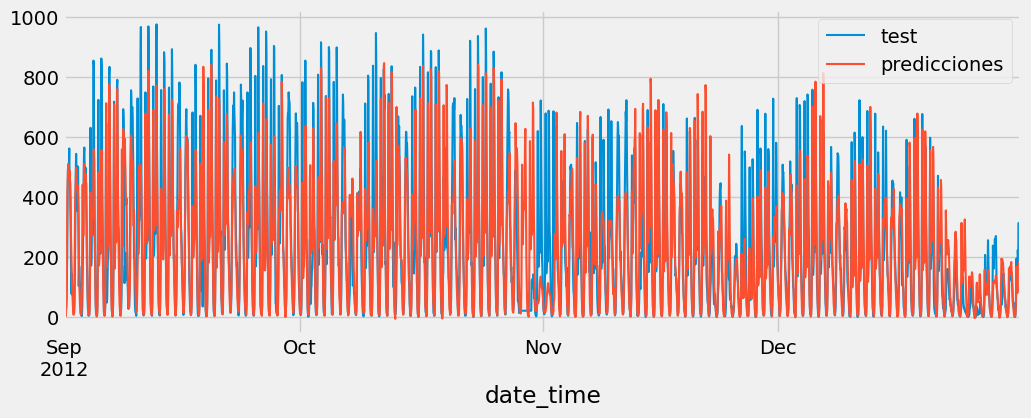

In [26]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['users'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [27]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['users'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de usuarios',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Incluir variables exógenas


In [28]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
datos['weather'] = datos['weather'].astype('category')
datos['month']   = datos['month'].astype('category')
datos['weekday'] = datos['weekday'].astype('category')

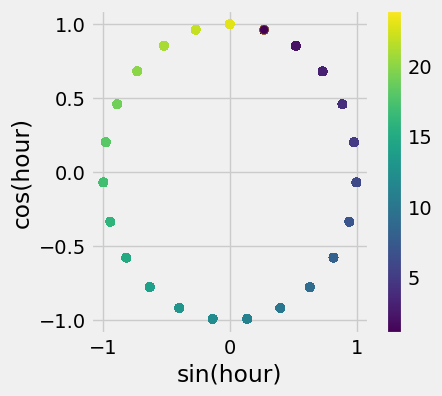

In [29]:
# Transformación seno-coseno de la variable hora
# ==============================================================================
datos['hour_sin'] = np.sin(datos['hour'] / 23 * 2 * np.pi)
datos['hour_cos'] = np.cos(datos['hour'] / 23 * 2 * np.pi)

# Representación de la transformación seno-coseno de la variable hora
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(datos["hour_sin"], datos["hour_cos"], c=datos["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

datos = datos.drop(columns='hour')

In [30]:
# One hot encoding
# ==============================================================================
datos = pd.get_dummies(datos, columns=['weather', 'month', 'weekday'])
datos.head(3)

holiday  workingday  temp   atemp   hum  windspeed  \
date_time                                                                 
2011-01-01 00:00:00        0           0  9.84  14.395  81.0        0.0   
2011-01-01 01:00:00        0           0  9.02  13.635  80.0        0.0   
2011-01-01 02:00:00        0           0  9.02  13.635  80.0        0.0   

                     users  TIPO_CONJUNTO  hour_sin  hour_cos  ...  month_10  \
date_time                                                      ...             
2011-01-01 00:00:00     16              0  0.269797  0.962917  ...         0   
2011-01-01 01:00:00     40              0  0.269797  0.962917  ...         0   
2011-01-01 02:00:00     32              0  0.519584  0.854419  ...         0   

                     month_11  month_12  weekday_1  weekday_2  weekday_3  \
date_time                                                                  
2011-01-01 00:00:00         0         0          0          0          0   
2011-01-01 01:00:00         0         0          0          0          0   
2011-01-01 02:00:00         0         0          0          0          0   

                     weekday_4  weekday_5  weekday_6  weekday_7  
date_time                                                        
2011-01-01 00:00:00          0          0          0          1  
2011-01-01 01:00:00          0          0          0          1  
2011-01-01 02:00:00          0          0          0          1  

[3 rows x 32 columns]

In [31]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding.
variables_exogenas = [column for column in datos.columns
                      if column.startswith(('weather', 'month', 'hour', 'weekday'))]
variables_exogenas.extend(['holiday', 'temp', 'atemp', 'hum', 'windspeed'])
print(variables_exogenas)

['hour_sin', 'hour_cos', 'weather_clear', 'weather_mist', 'weather_rain', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'holiday', 'temp', 'atemp', 'hum', 'windspeed']


In [32]:
# Como los datos han sido modificados, se repite el reparto en train, val y test.
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

In [33]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

In [34]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [02:31<00:00, 75.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 8764.879908440233



In [35]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: [6677.14366039]


In [36]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_BIKE_SHARING', connection_str = cnn)

(True, '')

Al incluir las variables exógenas como predictores, se consigue reducir el error de predicción aproximadamente a la mitad.

Importancia predictores

In [37]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.get_feature_importance()
importancia

feature  importance
0        lag_1    0.292309
1        lag_2    0.004027
2        lag_3    0.002855
3        lag_4    0.009516
4        lag_5    0.003842
..         ...         ...
96     holiday    0.001384
97        temp    0.001046
98       atemp    0.001740
99         hum    0.001605
100  windspeed    0.001007

[101 rows x 2 columns]

In [38]:
last_window = datos['users'][-forecaster.window_size:]
exog_future = datos[variables_exogenas].iloc[-2160:]
predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2013-01-01 00:00:00   28.428194
2013-01-01 01:00:00   22.855387
2013-01-01 02:00:00   13.554255
2013-01-01 03:00:00    7.192361
2013-01-01 04:00:00    6.791586
...                         ...
2013-03-31 19:00:00  140.053070
2013-03-31 20:00:00  107.223259
2013-03-31 21:00:00   83.213120
2013-03-31 22:00:00   59.918949
2013-03-31 23:00:00   34.384296

[2160 rows x 1 columns]

In [39]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_BIKE_SHARING', connection_str = cnn)

(True, '')

## LightGBM

In [40]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2024-07-04 13:04:17 
Last fit date: None 
Skforecast version: 0.4.2 

In [41]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


loop param_grid:   8%|███                                  | 1/12 [00:03<00:33,  3.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  17%|██████▏                              | 2/12 [00:05<00:29,  2.93s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



loop param_grid:  25%|█████████▎                           | 3/12 [00:08<00:23,  2.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  33%|████████████▎                        | 4/12 [00:11<00:23,  2.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069



loop param_grid:  42%|███████████████▍                     | 5/12 [00:14<00:19,  2.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:18<00:20,  3.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:20<00:14,  2.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:23<00:11,  2.84s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:25<00:07,  2.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:28<00:05,  2.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:31<00:02,  2.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18674
[LightGBM] [Info] Number of data points in the train set: 10872, number of used features: 101
[LightGBM] [Info] Start training from score 147.709069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:   8%|███                                  | 1/12 [00:02<00:24,  2.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:  17%|██████▏                              | 2/12 [00:04<00:22,  2.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:  25%|█████████▎                           | 3/12 [00:06<00:19,  2.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  33%|████████████▎                        | 4/12 [00:08<00:18,  2.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197



loop param_grid:  42%|███████████████▍                     | 5/12 [00:11<00:15,  2.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:13<00:13,  2.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:15<00:11,  2.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:18<00:09,  2.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:20<00:06,  2.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:22<00:04,  2.28s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:24<00:02,  2.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 10871, number of used features: 38
[LightGBM] [Info] Start training from score 147.722197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:02<00:00, 31.01s/it]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18677
[LightGBM] [Info] Number of data points in the train set: 14544, number of used features: 101
[LightGBM] [Info] Start training from score 178.556724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 

In [42]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

lags  \
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
23                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
19                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params        metric  \
11  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   8343.578678   
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   8774.820558   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   9020.752963   
23  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   9656.056805   
10  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   9875.959908   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  10044.220003   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  10405.547303   
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  10706.463283   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  11228.060077   
5   {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  11707.588775   

    learning_rate  max_depth  n_estimators  
11           0.10       10.0         500.0  
9            0.10        5.0         500.0  
7            0.10        3.0         500.0  
23           0.10       10.0         500.0  
10           0.10       10.0         100.0  
21           0.10        5.0         500.0  
19           0.10        3.0         500.0  
8            0.10        5.0         100.0  
22           0.10       10.0         100.0  
5            0.01       10.0         500.0

In [43]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18677
[LightGBM] [Info] Number of data points in the train set: 14544, number of used features: 101
[LightGBM] [Info] Start training from score 178.556724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Error de backtest: [5845.66570667]


In [44]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS_LGBM')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_BIKE_SHARING', connection_str = cnn)

(True, '')

In [45]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

feature  importance
0        lag_1         802
1        lag_2         318
2        lag_3         216
3        lag_4         255
4        lag_5         183
..         ...         ...
96     holiday          15
97        temp         189
98       atemp         184
99         hum         345
100  windspeed         230

[101 rows x 2 columns]

In [46]:
last_window = datos['users'][-forecaster.window_size:]
exog_future = datos[variables_exogenas].iloc[-2160:]
predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2013-01-01 00:00:00   28.544099
2013-01-01 01:00:00   15.627142
2013-01-01 02:00:00    9.951680
2013-01-01 03:00:00    6.846379
2013-01-01 04:00:00    7.218369
...                         ...
2013-03-31 19:00:00  103.722259
2013-03-31 20:00:00   81.106804
2013-03-31 21:00:00   63.435004
2013-03-31 22:00:00   44.380343
2013-03-31 23:00:00   28.654497

[2160 rows x 1 columns]

In [47]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS_LGBM')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_BIKE_SHARING', connection_str = cnn)

(True, '')

## CatBoost

In [48]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001D8FB990DD0> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2024-07-04 13:05:26 
Last fit date: None 
Skforecast version: 0.4.2 

In [49]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'users'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [06:31<00:00, 195.68s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 7499.19044665599



In [50]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

lags  \
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
23                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
19                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
22                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params        metric  \
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   7499.190447   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   8334.853611   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   9608.158163   
11  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   9610.790707   
23  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   9798.295081   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  10314.149595   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  10500.034604   
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  11059.736913   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  11311.029274   
10  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  11505.690532   

    learning_rate  max_depth  n_estimators  
9             0.1        5.0         500.0  
21            0.1        5.0         500.0  
7             0.1        3.0         500.0  
11            0.1       10.0         500.0  
23            0.1       10.0         500.0  
19            0.1        3.0         500.0  
22            0.1       10.0         100.0  
8             0.1        5.0         100.0  
20            0.1        5.0         100.0  
10            0.1       10.0         100.0

In [51]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: [5458.66714706]


In [52]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS_CatBoost')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_BIKE_SHARING', connection_str = cnn)

(True, '')

In [53]:
last_window = datos['users'][-forecaster.window_size:]
exog_future = datos[variables_exogenas].iloc[-2160:]
predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2013-01-01 00:00:00   28.052314
2013-01-01 01:00:00   16.185347
2013-01-01 02:00:00    7.964237
2013-01-01 03:00:00    3.840724
2013-01-01 04:00:00    3.505768
...                         ...
2013-03-31 19:00:00  160.696318
2013-03-31 20:00:00  112.040437
2013-03-31 21:00:00   88.139454
2013-03-31 22:00:00   68.523844
2013-03-31 23:00:00   46.627848

[2160 rows x 1 columns]

In [54]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS_CatBoost')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_BIKE_SHARING', connection_str = cnn)

(True, '')

## LSTM

In [55]:
!pip install keras

In [56]:
pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.1
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.3
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat  

In [57]:
!pip install tensorflow

In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [59]:
# Convertir los datos a numpy array
train_data = datos_train['users'].values.reshape(-1, 1)
val_data = datos_val['users'].values.reshape(-1, 1)
test_data = datos_test['users'].values.reshape(-1, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [60]:
# Función para crear secuencias temporales
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Definir el número de pasos temporales
time_steps = 24

In [61]:
# Crear secuencias temporales para entrenamiento, validación y prueba
X_train, y_train = create_sequences(train_data_scaled, time_steps)
X_val, y_val = create_sequences(val_data_scaled, time_steps)
X_test, y_test = create_sequences(test_data_scaled, time_steps)

# Reshape de los datos para que sean aceptados por la red LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [62]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0153 - val_loss: 0.0250
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0067 - val_loss: 0.0117
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0040 - val_loss: 0.0100
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0036 - val_loss: 0.0094
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 9/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0023 - val_loss: 0.0054
Epoch 10/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 11/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 12/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/st

In [63]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print("Loss en el conjunto de prueba:", loss)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043
Loss en el conjunto de prueba: 0.003550175577402115


In [64]:
# Predecir en el conjunto de prueba
predictions = model.predict(X_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [65]:
# Desescalar las predicciones
predictions_descaled = scaler.inverse_transform(predictions)

# Mostrar algunas predicciones
for i in range(5):
    print("Predicción:", predictions_descaled[i][0])

Predicción: 114.505585
Predicción: 75.01089
Predicción: 54.08192
Predicción: 66.44406
Predicción: 25.802465


In [66]:
# Crear un DataFrame con las fechas y las predicciones del modelo LSTM
predicciones_df = pd.DataFrame(index=datos_test.index[time_steps:], columns=['pred'])
predicciones_df['pred'] = predictions_descaled
predicciones_df

pred
date_time                      
2012-09-02 00:00:00  114.505585
2012-09-02 01:00:00   75.010887
2012-09-02 02:00:00   54.081921
2012-09-02 03:00:00   66.444061
2012-09-02 04:00:00   25.802465
...                         ...
2012-12-31 19:00:00   83.973541
2012-12-31 20:00:00   92.860519
2012-12-31 21:00:00   74.037994
2012-12-31 22:00:00   71.441666
2012-12-31 23:00:00   49.128155

[2904 rows x 1 columns]

In [67]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones_df, 'MODEL_EXOGENEAS_LSTM')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_BIKE_SHARING', connection_str = cnn)

(True, '')

In [68]:
from datetime import timedelta
# Crear un rango de fechas futuro
start_date = pd.to_datetime('2013-01-01 00:00:00')
future_dates = [start_date + timedelta(hours=i) for i in range(90 * 24)]

# Utilizar los últimos datos conocidos para iniciar las predicciones
last_known_data = test_data_scaled[-time_steps:]

# Almacenar predicciones
future_predictions = []

for i in range(len(future_dates)):
    # Preparar el input para el modelo LSTM
    input_data = last_known_data.reshape((1, time_steps, 1))
    
    # Realizar la predicción
    prediction = model.predict(input_data)
    
    # Desescalar la predicción
    prediction_descaled = scaler.inverse_transform(prediction)
    
    # Almacenar la predicción
    future_predictions.append(prediction_descaled[0, 0])
    
    # Actualizar last_known_data para incluir la nueva predicción
    last_known_data = np.append(last_known_data[1:], prediction, axis=0)

# Crear un DataFrame con las fechas y las predicciones
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['pred'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [69]:
# Mostrar las primeras predicciones futuras
future_predictions_df

pred
2013-01-01 00:00:00  38.283569
2013-01-01 01:00:00  28.359646
2013-01-01 02:00:00  19.685312
2013-01-01 03:00:00  13.802073
2013-01-01 04:00:00  13.449643
...                        ...
2013-03-31 19:00:00  39.114445
2013-03-31 20:00:00  35.881382
2013-03-31 21:00:00  34.066109
2013-03-31 22:00:00  33.791401
2013-03-31 23:00:00  35.536167

[2160 rows x 1 columns]

In [70]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(future_predictions_df, 'MODEL_EXOGENEAS_LSTM')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_BIKE_SHARING', connection_str = cnn)

(True, '')

# recomendación
**truncar las tablas**
* PREDICCION_BIKE_SHARING
* FORECASTING_BIKE_SHARING